In [1]:
import sympy as sp
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from functools import reduce
from random import choice, random

In [3]:
%matplotlib inline

# Autonomous Market Maker
State of market maker consists of:
* `c` coin tokens for exchange
* `s` short tokens for exchange
* `l` long tokens in balance
* `c_r` coin tokens in reserve
* `s_r`, `l_r` short and long tokens in reserve (equal quantities) (ignore for now - this is just an optimization to reduce minting costs)
* `p` pool token debt

In [4]:
def solve_add_liquidity():
    c, cd, s, sd, cn, t = sp.symbols('c c^\prime s s^\prime c_n t')
    return sp.solve(
        [
            sp.Eq(t*(s + sd), c + cd), 
            cn - cd - sd 
        ], 
        [cd, sd]
    )[cd]

In [5]:
solve_add_liquidity()

(-c + c_n*t + s*t)/(t + 1)

In [6]:
def rebalance(state, c_new=0., target=None):
    c, s, l, c_r, p = state
    p += c_new
    # Split supplied liquidity between c, s (and same l) to achieve target s:c ratio
    # i.e. (s + s')*target = (c + c'), w/ c_new = c' + s'
    # i.e. (s + c_new - c')*target = (c + c')
    # i.e. c' = (s*target + c_new*target - c) / (1 + target)
    if target is None:
        target = c / s
    c_d = (s*target + c_new*target - c) / (1 + target)
    c += c_d
    l += c_new - c_d
    s += c_new - c_d
    state = [c, s, l, c_r,  p]
    return state

In [7]:
s0 = [0., 0., 0., 0.,  0.]
s1 = rebalance(s0, 1, 0.5)
s1

[0.3333333333333333, 0.6666666666666667, 0.6666666666666667, 0.0, 1.0]

In [8]:
rebalance(s1, 1)

[0.6666666666666666, 1.3333333333333335, 1.3333333333333335, 0.0, 2.0]

In [9]:
def solve_buy():
    c, s, ds, dc = sp.symbols('c s Delta_s Delta_c')
    # Uniswap style constant product AMM
    invariant = c * s - (c + dc)*(s - ds)
    return sp.solve(invariant, ds)[0]

In [10]:
solve_buy()

Delta_c*s/(Delta_c + c)

In [11]:
def buy(state, dc):
    """Buy a short token from AMM
    """
    c, s, l, c_r, p = state
    ds = dc*s/(c + dc)
    c += dc
    s -= ds
    state = [c, s, l, c_r,  p]
    return state

In [12]:
# sell(buy(s1, 0.25), 1)

In [13]:
def solve_sell():
    c, s, dc, ds = sp.symbols('c s Delta_c Delta_s')
    # Uniswap style constant product AMM
    invariant = c * s - (c - dc)*(s + ds)
    return sp.solve(invariant, dc)[0]

In [14]:
solve_sell()

Delta_s*c/(Delta_s + s)

In [15]:
def sell(state, ds):
    """Sell a short token to AMM
    """
    c, s, l, c_r, p = state
    dc = ds*c/(s + ds)
    c -= dc
    s += ds
    state = [c, s, l, c_r,  p]
    return state

In [16]:
def balance(state):
    c, s, l, c_r, p = state
    return c + min(s, l)

In [17]:
def price(state):
    c, s, l, c_r, p = state
    return c/s

In [18]:
def invariant(state):
    c, s, l, c_r, p = state
    return c*s

In [19]:
balance(buy(s1, 0.25))

0.9642857142857142

In [20]:
rebalance(buy(s1, 0.25), 0., 0.5)

[0.3214285714285714, 0.6428571428571428, 0.9285714285714286, 0.0, 1.0]

In [21]:
balance(rebalance(buy(s1, 0.25), 0., 0.5))

0.9642857142857142

In [22]:
price(rebalance(buy(s1, 0.1), 0., 0.5))

0.5

In [23]:
rebalance(s1, 0., 0.9)

[0.4736842105263158, 0.5263157894736842, 0.5263157894736842, 0.0, 1.0]

In [24]:
c, s, l, c_r, p, t, ds, dc = sp.symbols('c s l c_r p t \Delta_s \Delta_c')

In [25]:
# General state
s_g = [c, s, l, c_r, p] 

In [26]:
rebalance(s_g, dc, t)[0]

c + (\Delta_c*t - c + s*t)/(t + 1)

Quantity of STK bought for $\Delta_c$ CTK

In [27]:
(s - buy(s_g, dc)[1]).simplify()

\Delta_c*s/(\Delta_c + c)

In [28]:
s1

[0.3333333333333333, 0.6666666666666667, 0.6666666666666667, 0.0, 1.0]

In [29]:
invariant(s1)

0.22222222222222224

In [30]:
invariant(rebalance(s1, 0, 1))

0.25

In [31]:
invariant(rebalance(s1, 0, 0.1))

0.0826446280991736

In [32]:
invariant(s_g)

c*s

In [33]:
sp.limit(invariant(rebalance(s_g, 0, t)), t, 1).factor()

(c + s)**2/4

In [34]:
rebalance(s_g, 0, t)[0].simplify()

t*(c + s)/(t + 1)

In [35]:
rebalance(s_g, 0, t)[1].simplify()

(c + s)/(t + 1)

In [36]:
(rebalance(s_g, 0, t)[0] + rebalance(s_g, 0, t)[1]).simplify()

c + s

In [37]:
rebalance(s1, -0.5, 0.5)

[0.16666666666666669, 0.33333333333333337, 0.33333333333333337, 0.0, 0.5]

Withdraw liquidity from the AMM in return for fraction of the balance

In [38]:
def withdraw(state, ptk):
    c, s, l, c_r, p = state
    t =  c / s
    b = balance(state)
    b_w = b * ptk / p
    p -= ptk
    c -= b_w
    new_state = [c, s, l, c_r,  p]
    final_state = rebalance(new_state, 0, t)
    return final_state

In [39]:
balance(withdraw(buy(s1, 0.1), 1))

0.0

In [40]:
balance(buy(s1, 0.4))

1.0363636363636364

In [41]:
actions = [(buy, 0.1), (sell, 0.1), (withdraw, 0.1), (rebalance, random)]

In [42]:
def run_simulation(n_steps=10, c_init=1., actions=None, fee=0.):
    s0 = [0., 0., 0., 0.,  0.]
    # Trader coin and short balance
    c_t = 1.
    s_t = 0.
    state = rebalance(s0, c_init, 0.5)
    res = [state + ['init', 0., c_t, s_t]]
    if actions is None:
        actions = ['buy', 'rebalance', 'sell', 'rebalance'] # , 'rebalance' 'withdraw']
    for i in range(n_steps):
        action = actions[i % len(actions)]
        v = 0.01
        if action == 'buy':
            new_state = buy(state, v)
            c_t -= v
            s_bought = state[1] - new_state[1]
            s_fee = fee*s_bought
            s_t += s_bought - s_fee
            new_state[1] += s_fee
        elif action == 'sell':
            v = s_t
            new_state = sell(state, v)
            c_proceeds = state[0] - new_state[0]
            c_fee = c_proceeds * fee
            s_t -= v
            c_t += c_proceeds - c_fee
            new_state[0] += c_fee
        elif action == 'withdraw':
            new_state = withdraw(state, v)
        elif action == 'rebalance':
            v = random()
            new_state = rebalance(state, 0., v)
        res.append(new_state + [action, v, c_t, s_t])
        if balance(new_state) < 0:
            break
        state = new_state
    return res

In [43]:
df = pd.DataFrame(
    run_simulation(200, actions=None, fee=0.), 
    columns=['coin', 'short', 'long', 'reserve', 'pool', 'action', 'value', 'coin_trader', 'short_trader']
).assign(
    price=lambda x: price([x.coin, x.short, x.long, x.reserve, x.pool]),
    balance=lambda x: x.coin + pd.concat([x.long, x.short], axis=1).min(axis=1),
    net=lambda x: x.balance + x.coin_trader + x.short_trader
)


In [44]:
df

,coin,short,long,reserve,pool,action,value,coin_trader,short_trader,price,balance,net
0,0.333333,0.666667,0.666667,0.0,1.0,init,0.000000,1.000000,0.000000,0.500000,1.000000,2.0
1,0.343333,0.647249,0.666667,0.0,1.0,buy,0.010000,0.990000,0.019417,0.530450,0.990583,2.0
2,0.018431,0.972152,0.991569,0.0,1.0,rebalance,0.018959,0.990000,0.019417,0.018959,0.990583,2.0
3,0.018070,0.991569,0.991569,0.0,1.0,sell,0.019417,0.990361,0.000000,0.018223,1.009639,2.0
4,0.120402,0.889237,0.889237,0.0,1.0,rebalance,0.135399,0.990361,0.000000,0.135399,1.009639,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.250375,0.385226,0.385226,0.0,1.0,rebalance,0.649943,1.364399,0.000000,0.649943,0.635601,2.0
197,0.260375,0.370431,0.385226,0.0,1.0,buy,0.010000,1.354399,0.014795,0.702897,0.630806,2.0
198,0.137393,0.493413,0.508208,0.0,1.0,rebalance,0.278454,1.354399,0.014795,0.278454,0.630806,2.0
199,0.133393,0.508208,0.508208,0.0,1.0,sell,0.014795,1.358399,0.000000,0.262477,0.641601,2.0


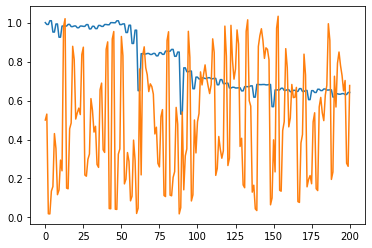

In [45]:
_ = df.balance.plot()
_ = df.price.plot()